In [1]:
import numpy as np
from pydub import AudioSegment
from pydub.playback import play
import random
import sys
import io
import os
import glob
import IPython
from td_utils import *
%matplotlib inline

## Create Dataset

In [2]:
# Create Dataset :
def create_dataset():
    mohsen_count = 0
    yasin_count = 0
    for filename in os.listdir("./Sounds"):
        if filename.startswith("Mohsen"):
            padding = AudioSegment.silent(duration=10000)
            segment = AudioSegment.from_wav("./Sounds/" + filename)
            segment = segment[max(-10000,-1*len(segment)):]
            padding = padding.overlay(segment)
            padding.export("./Dataset/Mohsen/" + str(mohsen_count) + ".wav", format="wav")
            mohsen_count += 1
        if filename.startswith("Yasin"):
            padding = AudioSegment.silent(duration=10000)
            segment = AudioSegment.from_wav("./Sounds/" + filename)
            segment = segment[max(-10000,-1*len(segment)):]
            padding = padding.overlay(segment)
            padding.export("./Dataset/Yasin/" + str(yasin_count) + ".wav", format="wav")
            yasin_count += 1
    print('Dataset created successfully!')
# Run :
create_dataset()

Dataset created successfully!


# Test Dataset

In [2]:
yasin_test_path = './training_samples/Yasin/train_0.wav'
yasin_spec = stft(yasin_test_path)
IPython.display.Audio(yasin_test_path)

In [3]:
mohsen_test_path = './training_samples/Mohsen/train_0.wav'
mohsen_spec = stft(mohsen_test_path)
IPython.display.Audio(mohsen_test_path)

In [4]:
print(mohsen_spec.shape, yasin_spec.shape)

(101, 2206) (101, 2206)


In [5]:
Tx = 2206 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram

## Generator

In [6]:
def generate_data(batch_size):
    while True:
        X = []
        Y = []
        for i in range(batch_size):
            _x, _y = fetch_dataset(X='Mohsen', Y='Yasin')
            X.append(_x)
            Y.append(_y)
            yield np.array(X), np.array(Y)

# Model


In [7]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model, Sequential
from keras.datasets import mnist
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend as K
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Conv2D, Conv2DTranspose
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, RepeatVector
from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
def model(input_shape):

    X_input = Input(shape = input_shape)
      
    # Step 1: CONV layer
    #X = Conv2D(196, (15, 15))(X_input)                         # CONV2D
    #X = Conv1D(196, 15, strides=4)(X_input)                    # CONV1D
    #X = BatchNormalization()(X)                                # Batch normalization
    #X = Activation('relu')(X)                                  # ReLu activation
    #X = Dropout(0.8)(X)                                        # dropout (use 0.8)

    # Step 2: First GRU Layer Encode
    X = GRU(units = 128, return_sequences=True)(X_input)       # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Step 3: Second GRU Layer Encode
    X = GRU(units = 128, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    
    # Step 4: First GRU Layer Decode
    X = GRU(units = 196, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    
    # Step 5: Second GRU Layer Decode
    X = GRU(units = 101, return_sequences=True)(X)             # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)
    X = BatchNormalization()(X)                                # Batch normalization
    X = Dropout(0.8)(X)                                        # dropout (use 0.8)

    model = Model(inputs = X_input, outputs = X)
    
    return model


# Load | Compile the model


In [9]:
#model = load_model('./model.h5')
model = model(input_shape = (Tx, n_freq))

Let's print the model summary to keep track of the shapes.

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2206, 101)         0         
_________________________________________________________________
gru_1 (GRU)                  (None, 2206, 128)         88320     
_________________________________________________________________
dropout_1 (Dropout)          (None, 2206, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2206, 128)         512       
_________________________________________________________________
gru_2 (GRU)                  (None, 2206, 128)         98688     
_________________________________________________________________
dropout_2 (Dropout)          (None, 2206, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2206, 128)         512       
__________

## Fit Model 

In [11]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='mse', optimizer=opt)

In [15]:
model.fit_generator(generate_data(5), steps_per_epoch = 5, epochs=100)

Epoch 1/100
5/5 [==============================] - 58s 12s/step - loss: 4.9533
Epoch 2/100
5/5 [==============================] - 58s 12s/step - loss: 4.9390
Epoch 3/100
5/5 [==============================] - 59s 12s/step - loss: 4.9178
Epoch 4/100
5/5 [==============================] - 59s 12s/step - loss: 4.9365
Epoch 5/100
5/5 [==============================] - 59s 12s/step - loss: 4.9618
Epoch 6/100
5/5 [==============================] - 59s 12s/step - loss: 4.9286
Epoch 7/100
5/5 [==============================] - 59s 12s/step - loss: 4.9288
Epoch 8/100
5/5 [==============================] - 59s 12s/step - loss: 4.9020
Epoch 9/100
5/5 [==============================] - 59s 12s/step - loss: 4.9028
Epoch 10/100
5/5 [==============================] - 59s 12s/step - loss: 4.9351
Epoch 11/100
5/5 [==============================] - 59s 12s/step - loss: 4.8753
Epoch 12/100
5/5 [==============================] - 59s 12s/step - loss: 4.9203
Epoch 13/100
5/5 [==============================]

## Save Model

In [16]:
model.save('./model.h5')

# Making Predictions

In [27]:
x_test = stft("./training_samples/Mohsen/train_18.wav")

## Predict & Reconstruct

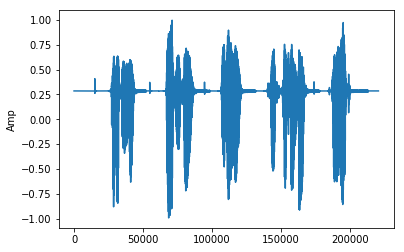

In [28]:
xrec = istft(x_test)
xrec = ((xrec + xrec.min()) * (2 ** 15) / xrec.ptp()).astype(np.int16)
wavfile.write('output.wav', 2206*10, xrec)
IPython.display.Audio("./output.wav")

## Predict

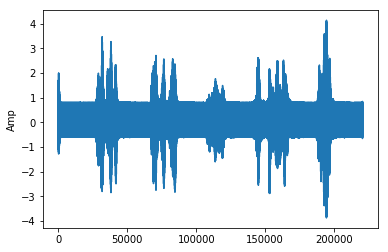

In [29]:
predicted = model.predict(np.array([x_test.T]))[0]
predicted = istft(predicted.T)
predicted = ((predicted + xrec.min()) * (2 ** 15) / predicted.ptp()).astype(np.int16)
wavfile.write('output_predict.wav', 2206*10, predicted)
IPython.display.Audio("./output_predict.wav")